In [1]:
import sys
import os
sys.path.append('..')

# from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization, training
from models.mtcnn import MTCNN
from models.inception_resnet_v1 import InceptionResnetV1
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from PIL import Image, ImageDraw, ImageFont
from IPython import display
import mmcv, cv2
import numpy as np
import pandas as pd

workers = 0 if os.name == 'nt' else 4

/home/nlpgpu5/anaconda3/envs/kwon/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/nlpgpu5/anaconda3/envs/kwon/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/nlpgpu5/anaconda3/envs/kwon/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/nlpgpu5/anaconda3/envs

#### Check Device

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


#### Define MTCNN (Pretrained)

In [3]:
mtcnn = MTCNN(
    image_size=160, margin=25, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    keep_all=True, device=device
)

#### Define InceptionResnetV1 and load fintuned model

In [4]:
resnet = InceptionResnetV1(classify=True, num_classes=23).to(device)
resnet.load_state_dict(torch.load('../data/fintuned_model.pt'))

<All keys matched successfully>

### DEMO

In [5]:
Name_dict = {
    0: 'Alexander-Arnold',
    1: 'Alisson',
    2: 'Fabinho',
    3: 'Firmino',
    4: 'Gomez',
    5: 'Henderson',
    6: 'Keita',
    7: 'Klopp',
    8: 'Lallana',
    9: 'Loveren',
    10: 'Mane',
    11: 'Matip',
    12: 'Mignolet',
    13: 'Milner',
    14: 'Moreno',
    15: 'Origi',
    16: 'Oxlade-Chamberlain',
    17: 'Robertson',
    18: 'Salah',
    19: 'Shaqiri',
    20: 'Sturridge',
    21: 'Van Dijk',
    22: 'Wijnaldum'
}

#### Image Demo

/home/nlpgpu5/anaconda3/envs/kwon/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


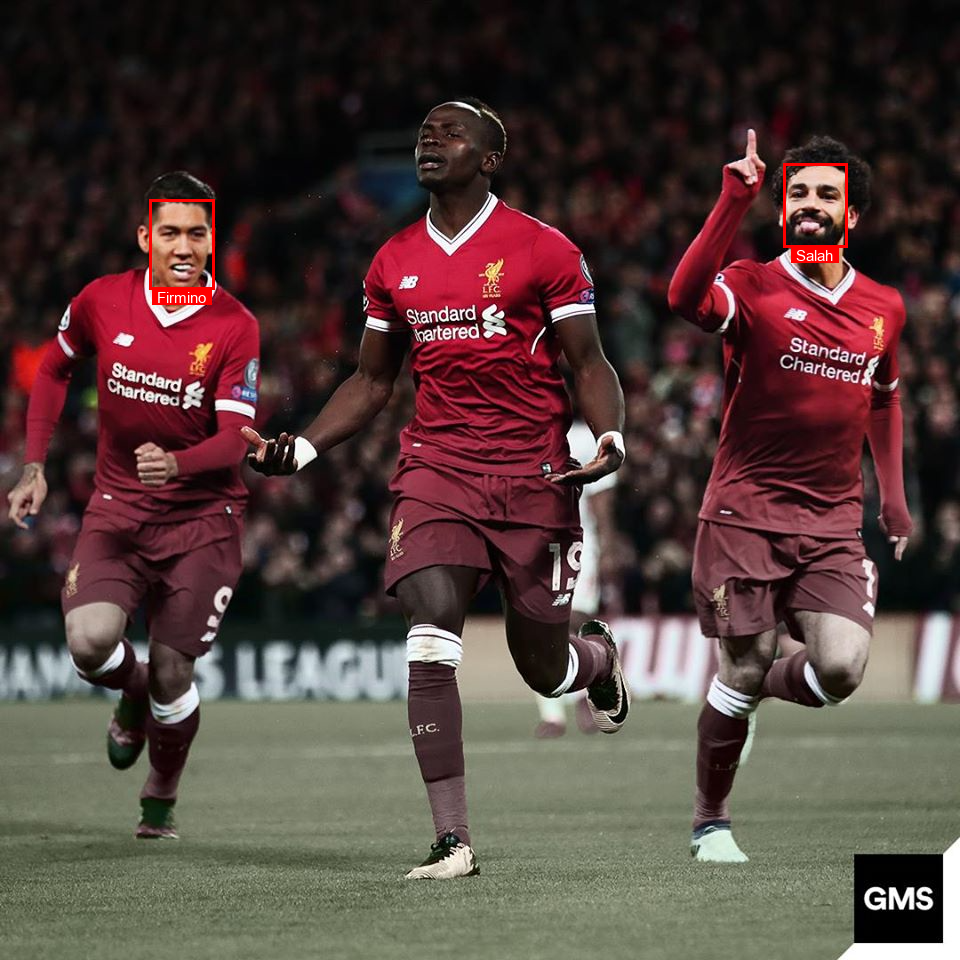

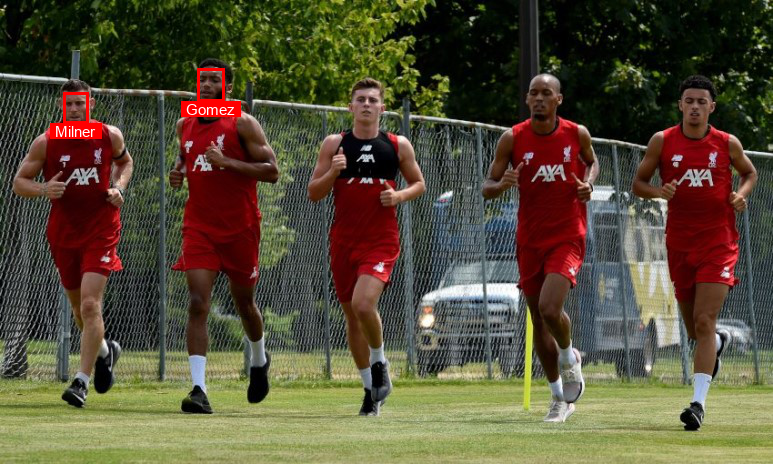

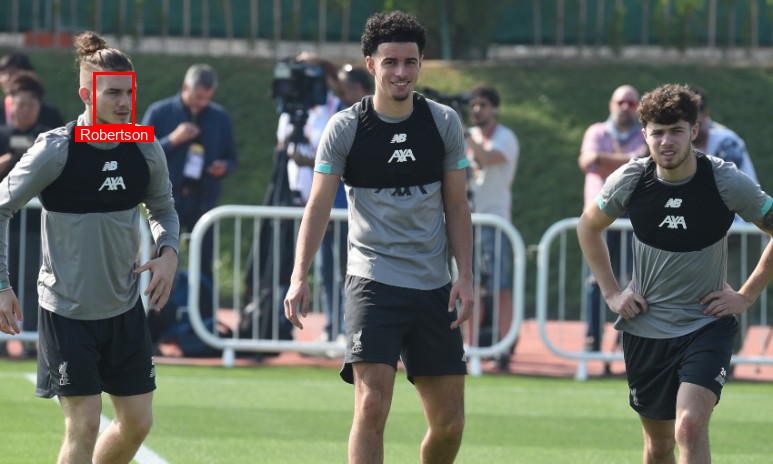

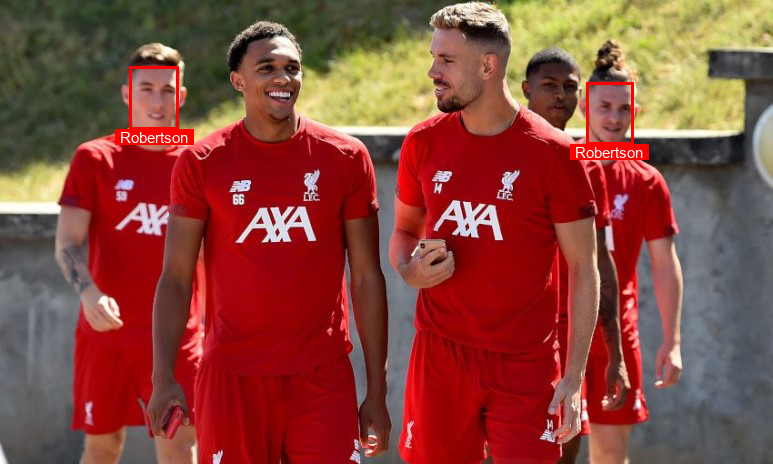

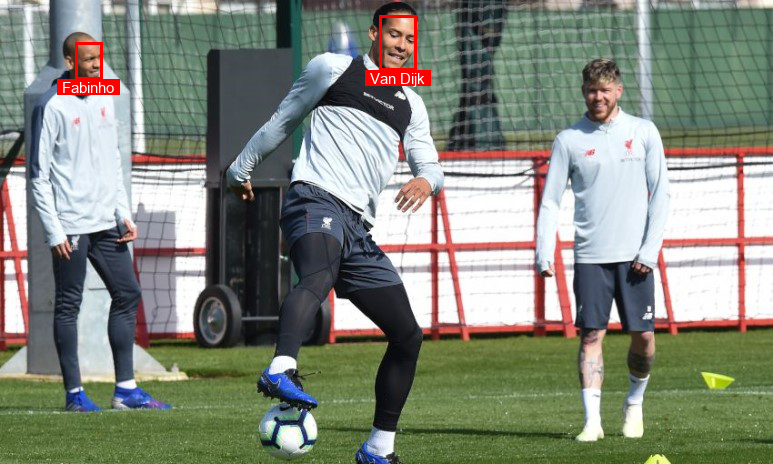

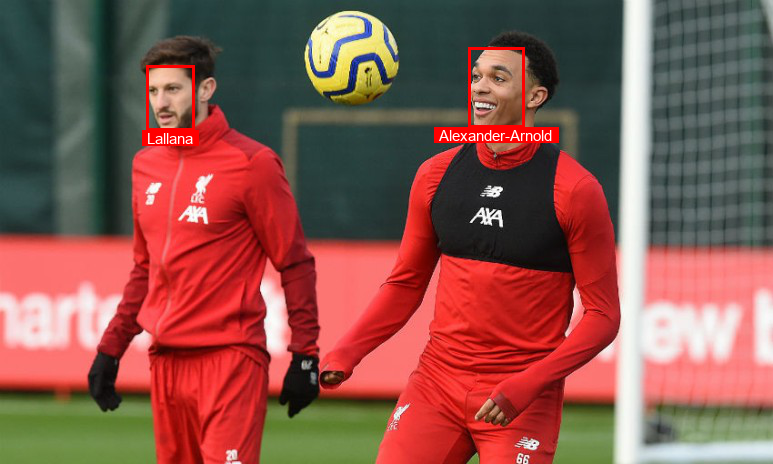

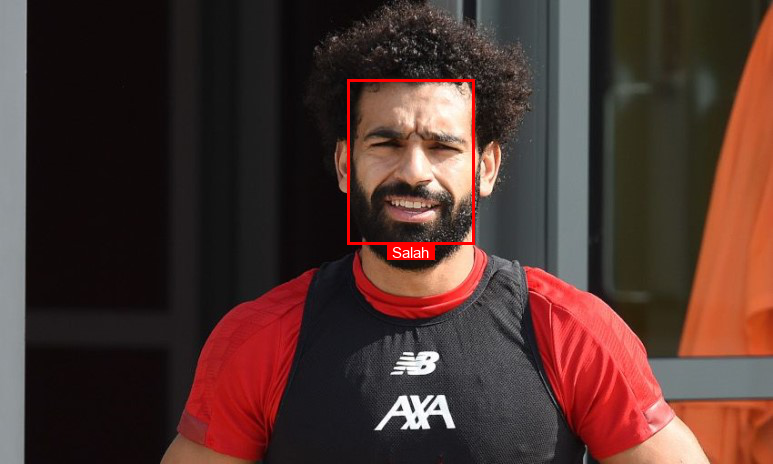

In [6]:
def collate_fn(x):
    return x[0]

dataset = datasets.ImageFolder('../data/Multi_Test')
dataset.idx_to_class = {i:c for c, i in dataset.class_to_idx.items()}
loader = DataLoader(dataset, collate_fn=collate_fn, num_workers=workers)

resnet.eval()
for x, _ in loader:
    logits = []
    # Get cropped face and their position
    T_imgs, _ = mtcnn(x) 
    boxes, _ = mtcnn.detect(x)
    
    # Append cropped face list
    for T_img in T_imgs:
        logits.append(resnet(T_img.reshape(1, 3, 160, 160).to(device)))
    
    # Draw box
    img_draw = x.copy()
    draw = ImageDraw.Draw(img_draw)
    v = None
    for box, logit in zip(boxes, logits):
        logit = torch.nn.functional.softmax(logit)
        v = torch.topk(logit, k=2)
        cls = torch.argmax(logit)
        if logit[0][cls] > 0.8 or (v[0][0][0] - v[0][0][1]) > 0.8:
            left, top, right, bottom = box[0], box[1], box[2], box[3]
            name = Name_dict[int(cls)]
            font = ImageFont.truetype("/usr/share/fonts/turetype/Arial.ttf", 15)
            w, h = draw.textsize(name, font=font)
            n_left = ((right + left) / 2) - (w / 2)
            n_right = n_left + w
            n_top = bottom
            n_bottom = n_top + 15
            draw.rectangle([left, top, right, bottom], outline=(255, 0, 0), width=3)
            draw.rectangle([n_left - 5, n_top, n_right + 5, n_bottom], fill=(255, 0, 0), outline=(255, 0, 0))
            draw.text([n_left, n_top], name, font=font)
    display.display(img_draw)

#### Video Demo

In [7]:
video = mmcv.VideoReader('../data/salah.mp4')
frames = [Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)) for frame in video]

display.Video('../data/celebration.mp4', width=640)

Tracking frame: 2

/home/nlpgpu5/anaconda3/envs/kwon/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Tracking frame: 68
Done


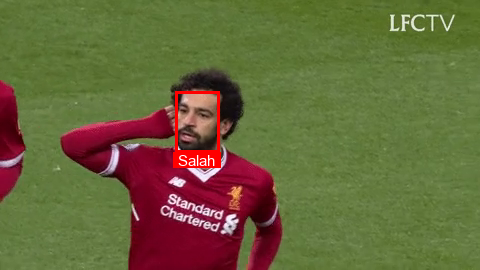

In [8]:
frames_tracked = []
for i, frame in enumerate(frames):
    logits = []
    print('\rTracking frame: {}'.format(i + 1), end='')
    
    # Detect faces
    T_imgs, _ = mtcnn(frame) 
    boxes, _ = mtcnn.detect(frame)
    
    # Append cropped face list
    if T_imgs is not None:
        for T_img in T_imgs:
            logits.append(resnet(T_img.reshape(1, 3, 160, 160).to(device)))
        
        # Draw faces
        frame_draw = frame.copy()
        draw = ImageDraw.Draw(frame_draw)
        v = None
        for box, logit in zip(boxes, logits):
            logit = torch.nn.functional.softmax(logit)
            v = torch.topk(logit, k=2)
            cls = torch.argmax(logit)
            if logit[0][cls] > 0.7 and (v[0][0][0] - v[0][0][1]) > 0.7:
                left, top, right, bottom = box[0], box[1], box[2], box[3]
                name = Name_dict[int(cls)]
                font = ImageFont.truetype("/usr/share/fonts/turetype/Arial.ttf", 15)
                w, h = draw.textsize(name, font=font)
                n_left = ((right + left) / 2) - (w / 2)
                n_right = n_left + w
                n_top = bottom
                n_bottom = n_top + 15
                draw.rectangle([left, top, right, bottom], outline=(255, 0, 0), width=3)
                draw.rectangle([n_left - 5, n_top, n_right + 5, n_bottom], fill=(255, 0, 0), outline=(255, 0, 0))
                draw.text([n_left, n_top], name, font=font)
    
    # Add to frame list
    frames_tracked.append(frame_draw)
print('\nDone')

d = display.display(frames_tracked[0], display_id=True)
i = 1
try:
    while True:
        d.update(frames_tracked[i % len(frames_tracked)])
        i += 1
except KeyboardInterrupt:
    pass